# **Generating Alpha for real CMB data**

We want to repeat the process of identification carried out on real CMB map data from before, but this time only using the cutouts which correspond to 'good' regions of our map, i.e. those not blocked when using a mask.

In [ ]:
!pip install healpy

     |████████████████████████████████| 15.8MB 201kB/s 


In [ ]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools

from matplotlib.colors import ListedColormap

In [ ]:
import os

# Mount google drive folder with .fits maps
from google.colab import drive
drive.mount('/content/drive')

# Change directory
os.chdir('drive/MyDrive/Project')

We can load up the array of maps generated previously

In [ ]:
cutouts = np.load('clean_planck_cutouts.npy')
cutouts = cutouts[..., np.newaxis]

# **Running the cutouts through the model**

We can now load our model and create a dataset to output values of alpha.

In [ ]:
# Load model
model = tf.keras.models.load_model('regression_model_val_loss_0_2314')

In [ ]:
def batch_standardisation(maps):
  epsilon = 1e-10
  mean, variance = tf.nn.moments(maps, axes=[0, 1, 2])
  denom = tf.math.sqrt(variance + epsilon)
  maps_standardised = (maps - mean)/denom
  return maps_standardised


Here we create our Planck dataset. We're still batching since we're using batch standardisation.

In [ ]:
clean_ds = tf.data.Dataset.from_tensor_slices((cutouts))
clean_ds = clean_ds.batch(16)
clean_ds = clean_ds.map(batch_standardisation)

Now we can save our predictions to a variable. This will contain the predicted value of $\alpha$ for each 'pixel'

In [ ]:
# Save predictions
predictions = model.predict(clean_ds)


In [ ]:
predicted_alphas = predictions*1e-6

We can save these predictions for further analysis without needing to run the model again

In [ ]:
np.save('clean_cmb_predictions.npy', predicted_alphas)

We can find the maximum and minimum for these predicted values of $\alpha$

In [ ]:
print(max(predicted_alphas))
print(min(predicted_alphas))

[1.3323537e-05]
[1.221322e-06]


And plot a histogram to investigate the results

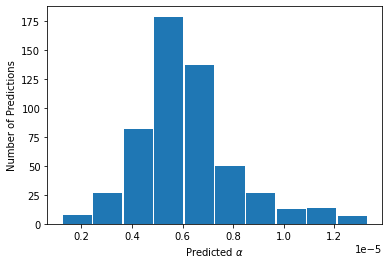

In [ ]:
fig, ax = plt.subplots()
ax.hist(predicted_alphas, rwidth=0.95)
ax.set_xlabel(r'Predicted $\alpha$')
ax.set_ylabel('Number of Predictions')

plt.savefig('clean_cmb_hist.png', dpi=300, bbox_inches='tight')